In [12]:
# 라이브러리 및 모듈 import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd
import cv2
import os
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as patches
from collections import Counter

sns.set_style("darkgrid")

## Data path Setting

In [13]:
annotation = '/root/eliceAI/dataset_root/annotations/train.json'
data_dir = '/root/eliceAI/dataset_root'

## DataFrame 생성

In [14]:
with open(annotation) as json_file:
    anns = json.load(json_file)

print(anns.keys())
# print(json.dumps(anns['info'], indent=4))
# print(json.dumps(anns['licenses'], indent=4))
# print(json.dumps(anns['images'], indent=4))
# print(json.dumps(anns['categories'], indent=4))
# print(json.dumps(anns['annotations'][0], indent=4))
print()

label_name = [ann_dict['name'] for ann_dict in anns['categories']]
print(f"labels : {label_name}")

def safe_get_label_name(category_id):
    if 1 <= category_id < len(label_name) + 1:
        return label_name[category_id - 1]
    else:
        return "Unknown"

df = pd.json_normalize(anns['annotations'])
df[["X","Y","W","H"]] = list(df.bbox)
df.drop(columns='bbox', inplace=True)
# df['WH_ratio'] = df['W']/df['H']
# df['HW_ratio'] = df['H']/df['W']
df['sqrt_area'] = np.sqrt(df['area'])
df['category_name'] = df['category_id'].apply(safe_get_label_name)
#df['category_name'] = df['category_id'].apply(lambda x: label_name[x])
df = df[['id', 'image_id', 'category_id', 'category_name', 'area', 'sqrt_area', 'X', 'Y', 'W', 'H', 'iscrowd']]
if len(df['iscrowd'].unique()) == 1:
    df.drop(columns='iscrowd', inplace=True)

print(f"num of image : {len(df['image_id'].unique())}")
df.sample(10)

dict_keys(['images', 'categories', 'annotations'])

labels : ['crack', 'pothole']
num of image : 24271


,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
38375,38376,7973,1,crack,47322,217.536204,548.0,114.0,99.0,478.0
64064,64065,13190,1,crack,9772,98.853427,493.0,253.0,28.0,349.0
88012,88013,18151,1,crack,893,29.883106,2.0,345.0,19.0,47.0
69560,69561,14323,1,crack,3953,62.872888,616.0,291.0,67.0,59.0
107552,107553,22250,1,crack,440,20.976177,447.0,301.0,44.0,10.0
12836,12837,2651,1,crack,744,27.276363,197.0,209.0,31.0,24.0
95349,95350,19670,1,crack,846,29.086079,1022.0,297.0,94.0,9.0
115950,115951,23978,1,crack,61952,248.901587,147.0,263.0,176.0,352.0
10523,10524,2159,1,crack,696,26.381812,1164.0,236.0,29.0,24.0
115994,115995,23983,1,crack,644,25.377155,828.0,188.0,28.0,23.0


## DF Describe

In [15]:
df.describe().round(2)

,id,image_id,category_id,area,sqrt_area,X,Y,W,H
count,117358.00,117358.00,117358.00,117358.00,117358.00,117358.00,117358.00,117358.00,117358.00
mean,58679.50,12121.85,1.06,15839.08,83.24,510.81,255.84,141.83,81.35
std,33878.48,6997.05,0.23,39105.26,94.39,314.09,155.14,167.99,118.79
min,1.00,0.00,1.00,9.00,3.00,0.00,0.00,3.00,3.00
25%,29340.25,6076.00,1.00,572.00,23.92,272.00,131.00,41.00,11.00
50%,58679.50,12096.50,1.00,2208.00,46.99,511.00,238.00,81.00,33.00
75%,88018.75,18152.00,1.00,10304.00,101.51,726.00,368.00,174.00,91.00
max,117358.00,24270.00,2.00,680447.00,824.89,1273.00,707.00,1280.00,681.00


## Class 분포
- 전체 오브젝트들의 class 분포를 살펴봅니다.

AttributeError: 'Series' object has no attribute 'iteritems'

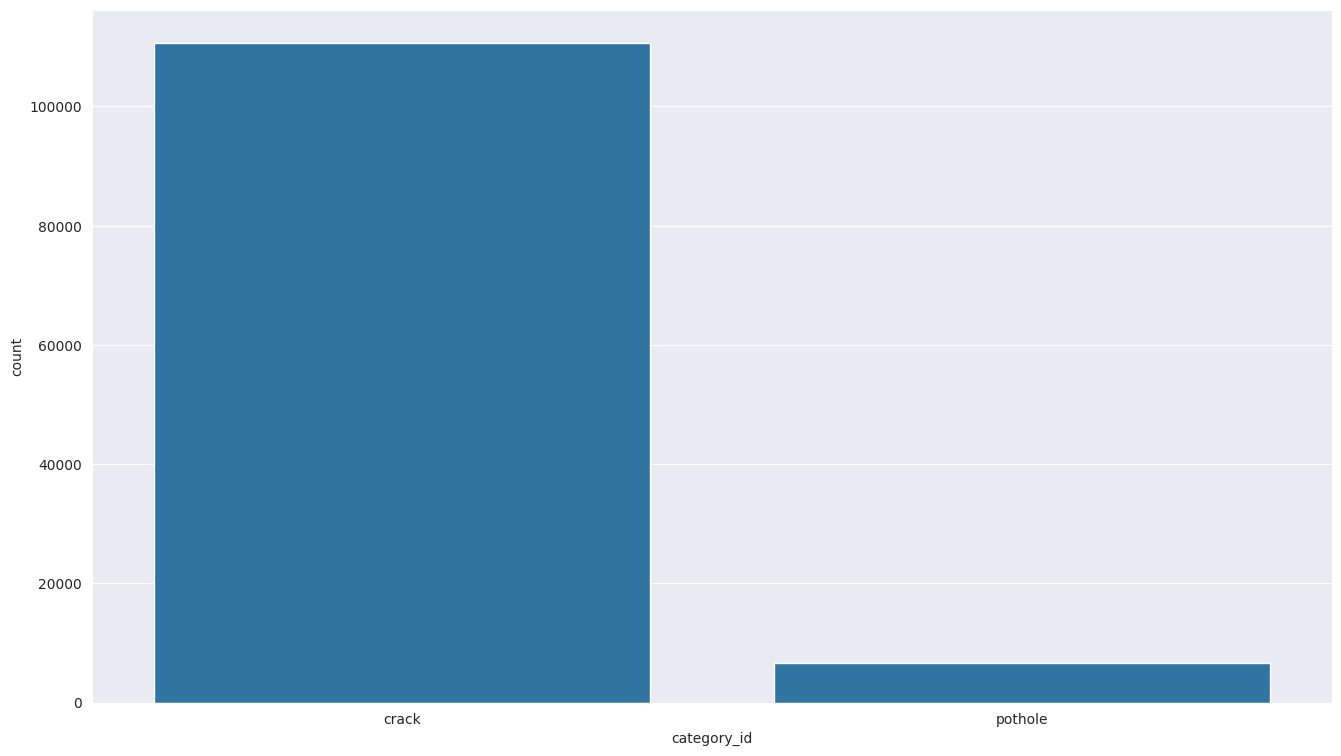

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='category_id', data=df, ax=ax)
ax.set(xticks=range(len(label_name)), xticklabels=label_name)

for idx, val in df['category_id'].value_counts().sort_index().iteritems():
    ax.text(x=idx, y=val, s=val,
            va='bottom', ha='center',
            fontsize=10, fontweight='semibold'
           )


for idx, val in df['category_id'].value_counts().sort_index().items():
    ax.text(x=idx, y=val + 0.1, s=val,  # 막대의 상단보다 약간 위에 위치
            va='bottom', ha='center',
            fontsize=10, fontweight='semibold')

plt.show()

## Image당 지표 확인
- 전체 데이터에서 이미지당 포함된 class의 갯수와 object의 갯수를 추출합니다.

In [11]:
img_by = df[['image_id', 'category_id']].groupby(['image_id']).agg([pd.Series.count, pd.Series.nunique])
img_by.columns = list(map(lambda x: 'cat_' + x[1],img_by.columns))
img_by.sample(10)

,cat_count,cat_nunique
image_id,,
22256,3,1
11493,7,1
13708,4,1
4573,6,1
14385,1,1
6870,8,1
20175,4,1
351,5,1
22837,2,1


In [12]:
img_by.describe()

,cat_count,cat_nunique
count,24271.000000,24271.000000
mean,4.835318,1.089984
std,3.122052,0.286165
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,1.000000
75%,7.000000,1.000000
max,34.000000,2.000000


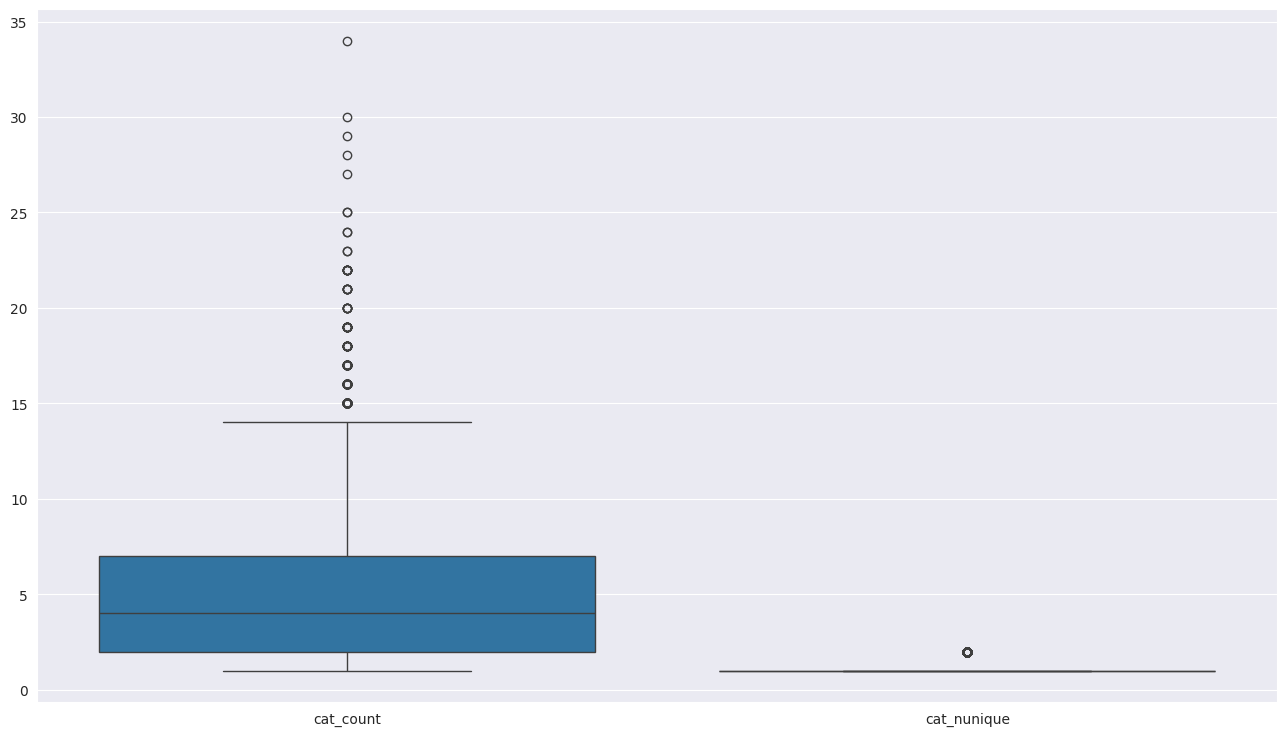

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
# sns.kdeplot(x='W', y='H', hue='category_name', data=df, ax=ax)
sns.boxplot(data=img_by, ax=ax)
plt.show()

## Image당 지표 시각화

AttributeError: 'Series' object has no attribute 'iteritems'

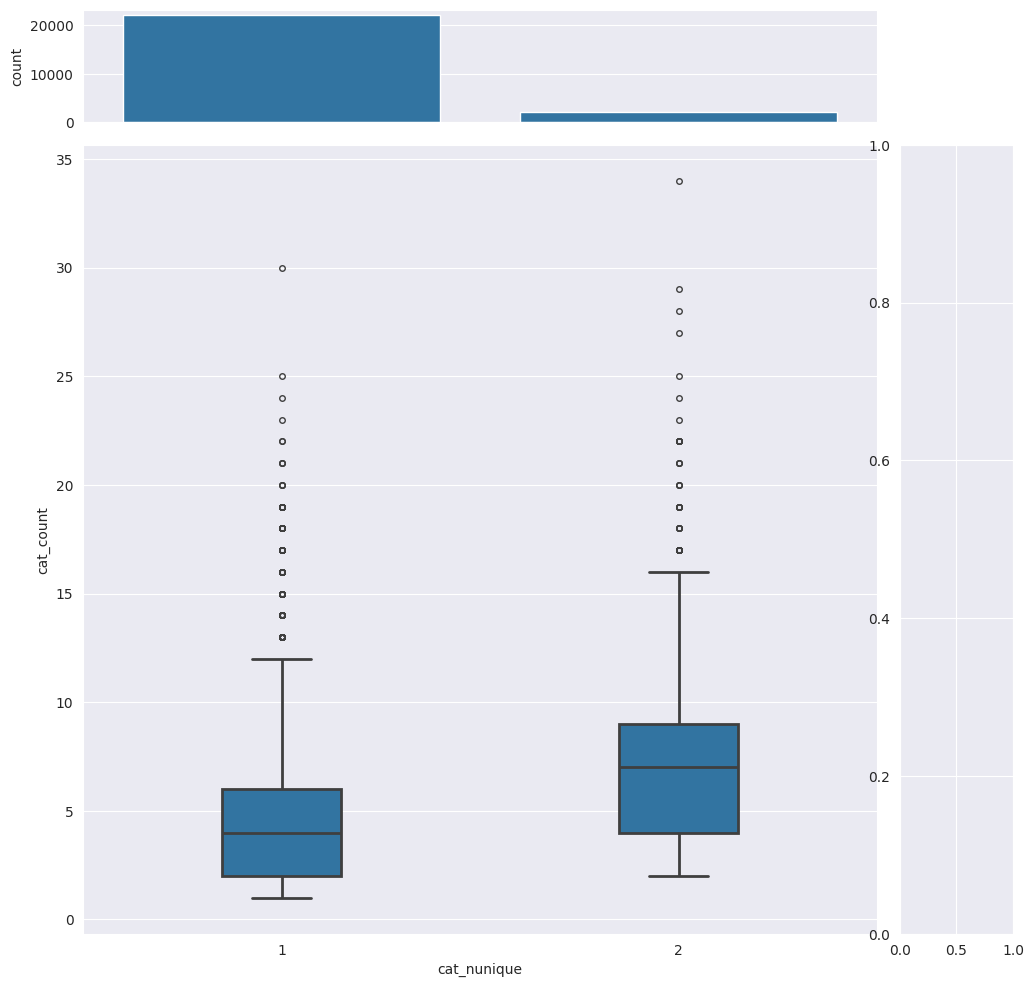

In [14]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(7, 7) # make 3 by 3 grid (row, col)
axes = [None for _ in range(3)]

axes[0] = fig.add_subplot(gs[0, :6])
axes[1] = fig.add_subplot(gs[1:, :6])
axes[2] = fig.add_subplot(gs[1:, 6])

sns.boxplot(x='cat_nunique', y='cat_count', data=img_by, width=0.3, linewidth=2, fliersize=4, ax=axes[1])
# sns.boxenplot(x='cat_nunique', y='cat_count', data=img_by, width=0.3, linewidth=2, ax=axes[1])
ylim = axes[1].get_ylim()

sns.countplot(x='cat_nunique', data=img_by, ax=axes[0])
# sns.histplot(x='cat_nunique', data=img_by, bins=6, ax=axes[0])
# axes[0].spines[['top', 'bottom', 'right']].set_visible(False)
axes[0].xaxis.set_visible(False)
# axes[0].grid()
for idx, val in img_by['cat_nunique'].value_counts().iteritems():
    if val > 2000:
        axes[0].text(x=idx-1, y=val-150, s=val,
                va='top', ha='center',
                fontsize=10, fontweight='semibold', color='w'
            )
    else:
        axes[0].text(x=idx-1, y=val, s=val,
                va='bottom', ha='center',
                fontsize=10, fontweight='semibold'
            )

sns.countplot(y='cat_count', data=img_by, order=list(range(img_by['cat_count'].max()+1)), ax=axes[2])
axes[2].set_ylim(ylim)
# sns.histplot(y='cat_count', data=img_by, bins=71, ax=axes[2])
# axes[2].spines[['top', 'right', 'left']].set_visible(False)
axes[2].yaxis.set_visible(False)
# axes[2].grid()
axes[2].axvline(x=100, color='royalblue', linestyle='--', linewidth=1, alpha=0.5)
axes[2].text(x=200, y=-1, s='100', color='royalblue',
            va='top', ha='left',
            fontsize=10, fontweight='semibold', alpha=0.7
           )

plt.tight_layout()
plt.show()

## Image 단위 지표 요약
- 대부분의 이미지당 오브젝트 5개 이하, 클래스종류 2개이하를 포함한다.


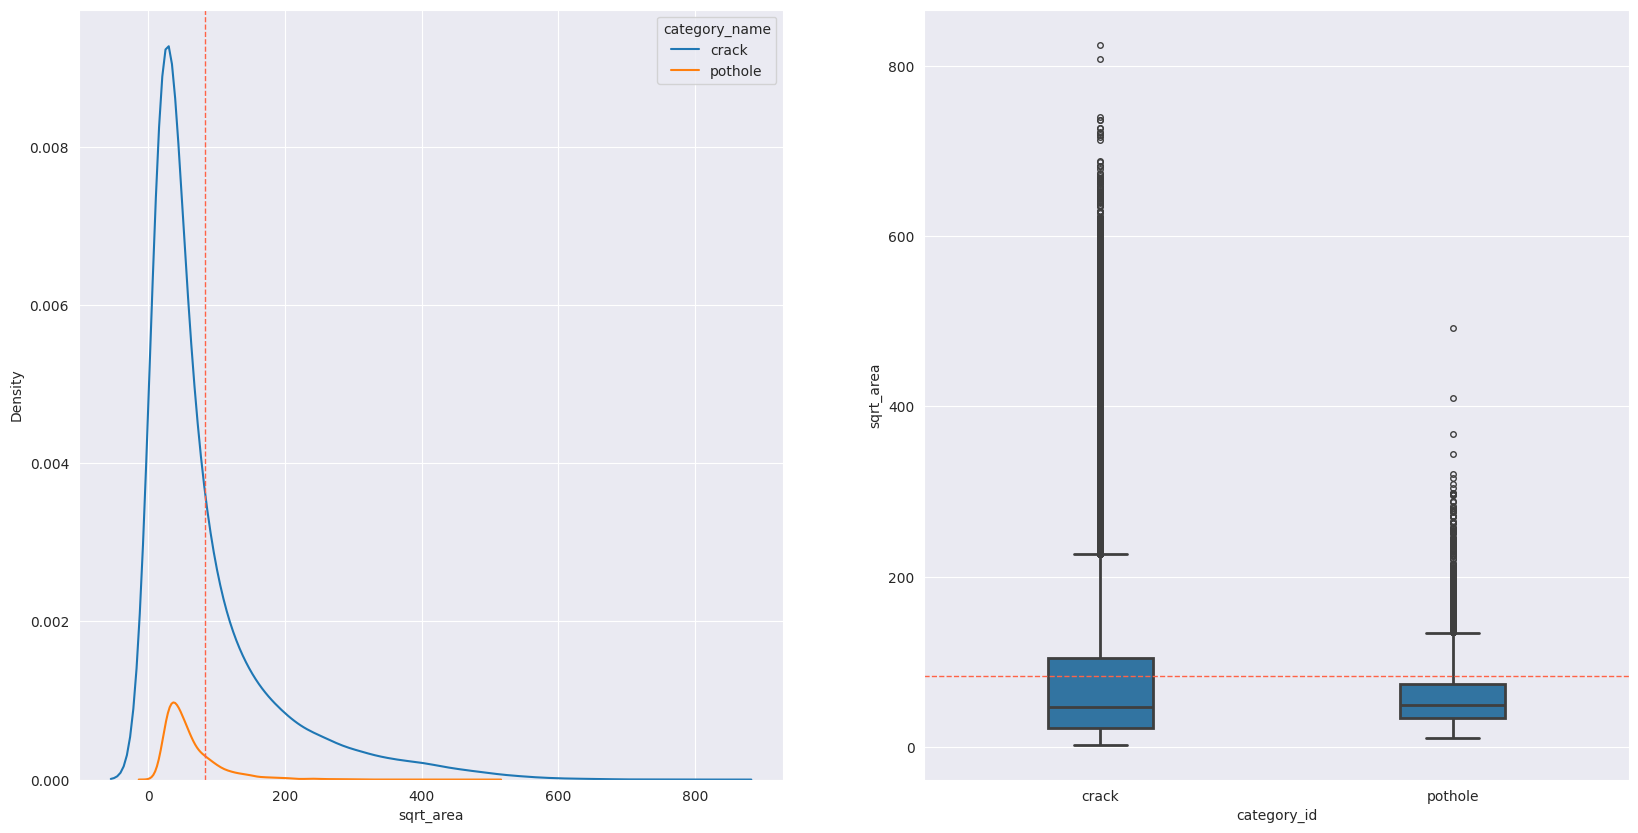

In [15]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.kdeplot(x='sqrt_area', hue='category_name', data=df, bw_method=0.2, ax=axes[0])
axes[0].axvline(x=df['sqrt_area'].mean(), color='tomato', linestyle='--', linewidth=1)

# sns.histplot(x='sqrt_area', hue='category_id' ,data=df, ax=axes[0])
sns.boxplot(x='category_id', y='sqrt_area', data=df, width=0.3, linewidth=2, fliersize=4, ax=axes[1])
axes[1].set(xticks=range(len(label_name)), xticklabels=label_name)
axes[1].axhline(y=df['sqrt_area'].mean(), color='tomato', linestyle='--', linewidth=1)
plt.show()

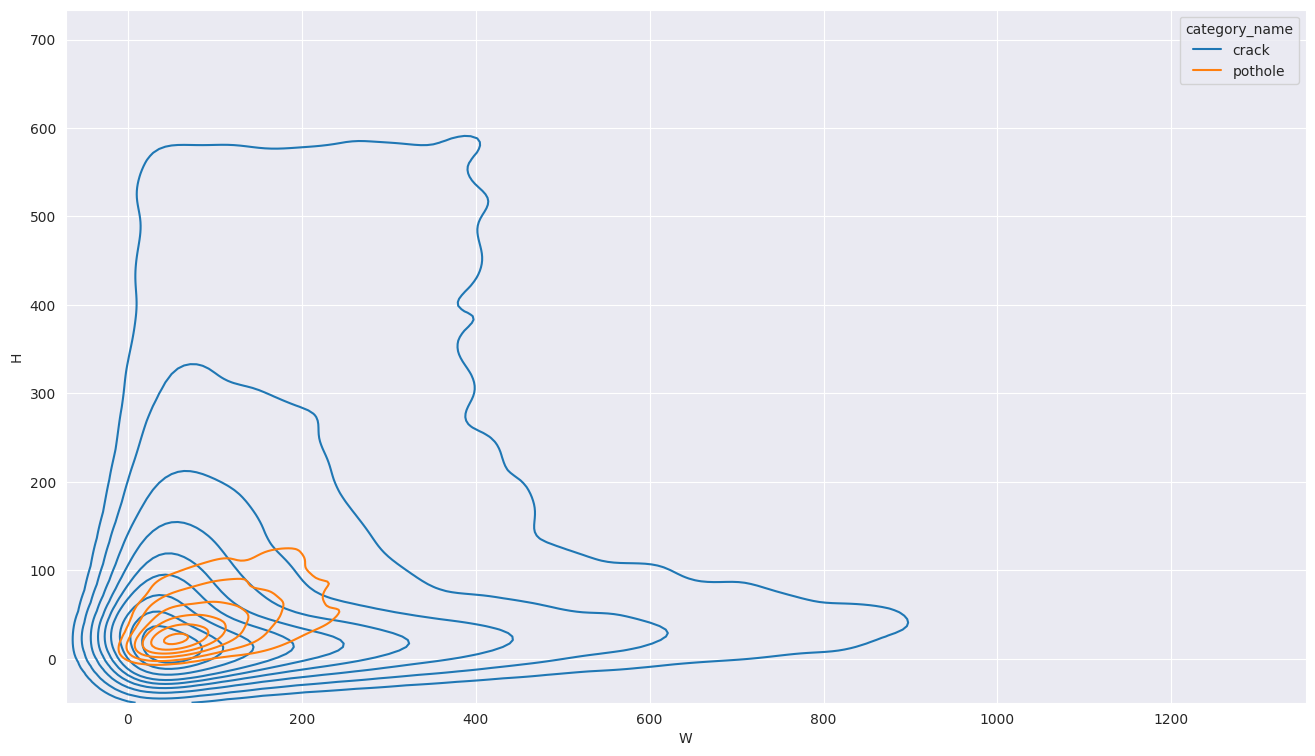

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(x='W', y='H', hue='category_name', data=df, ax=ax)
plt.show()

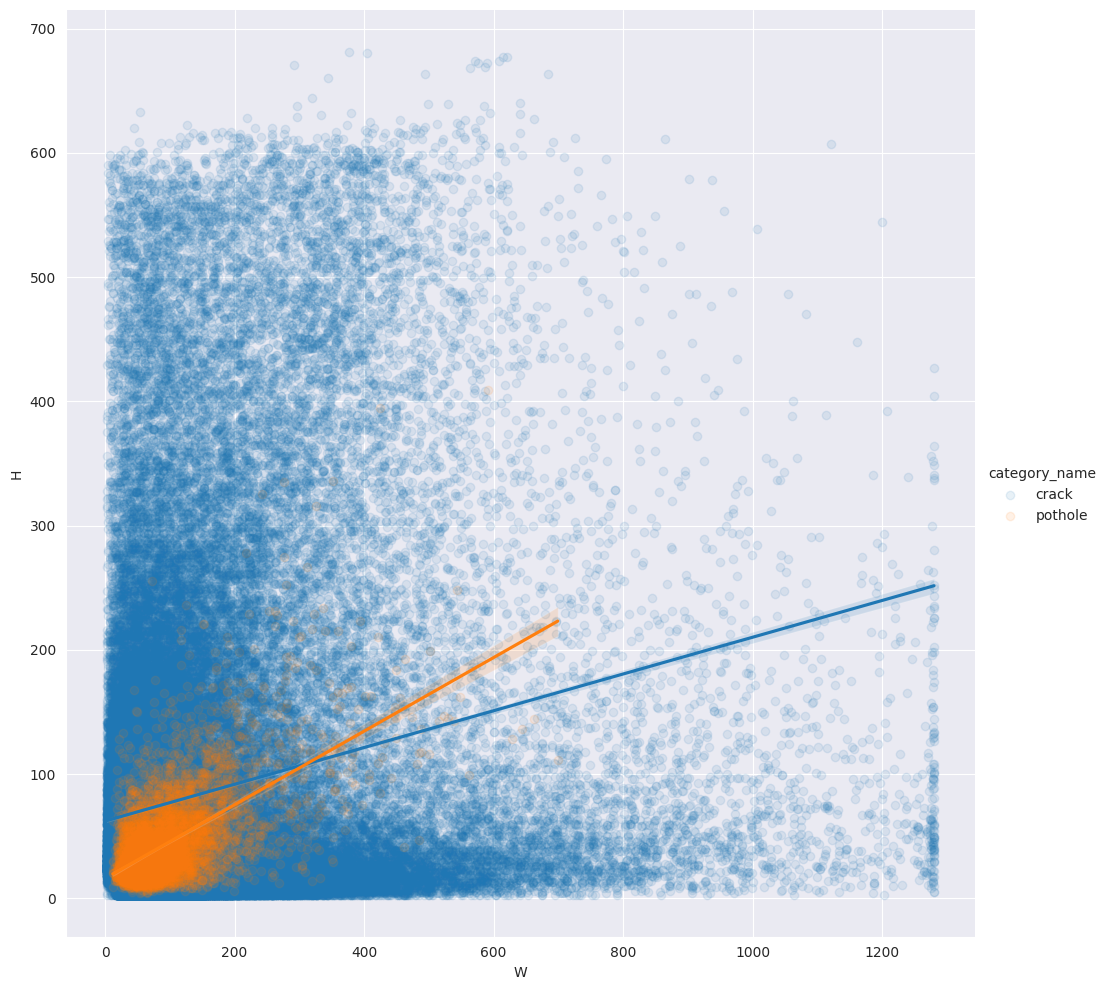

In [17]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='W', y='H', hue='category_name', data=df, scatter_kws={'alpha':0.1}, height=10)
plt.show()

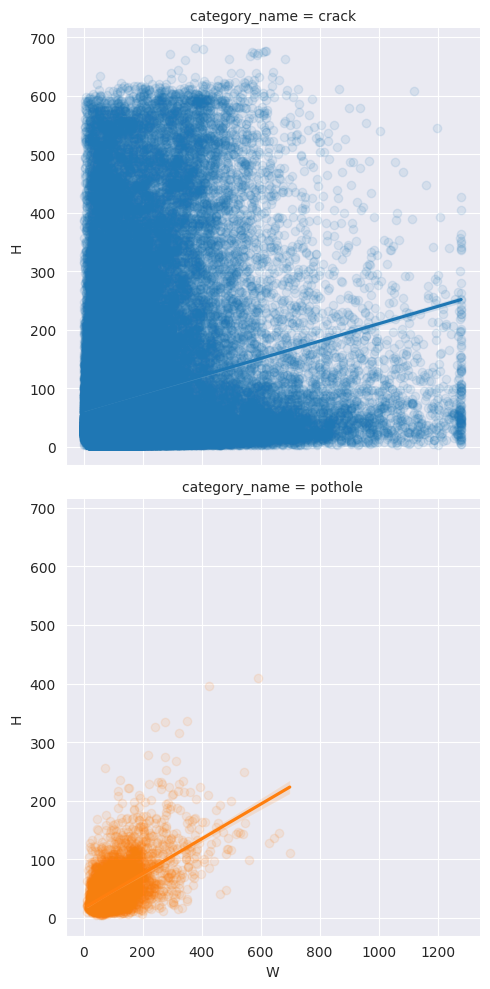

In [18]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='W', y='H', hue='category_name', data=df, row='category_name', scatter_kws={'alpha':0.1})
plt.show()

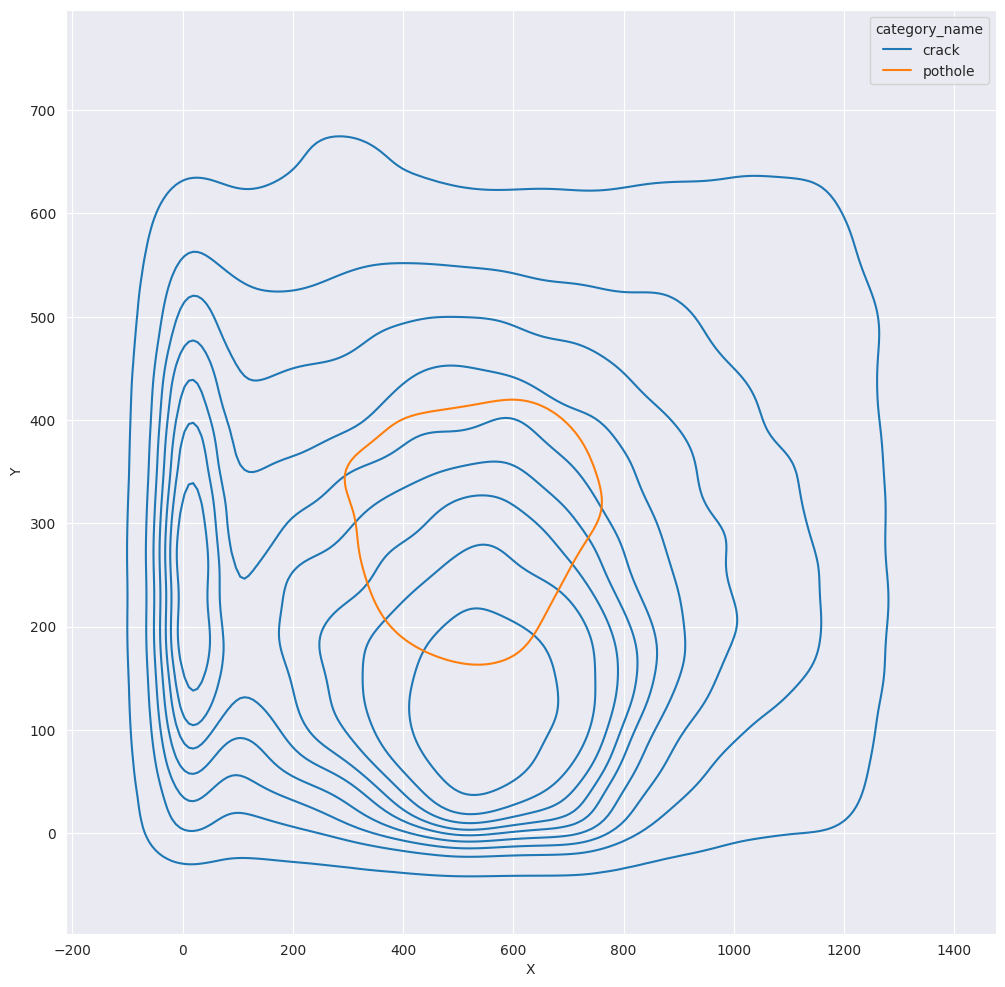

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(x='X', y='Y', hue='category_name', data=df, ax=ax)
plt.show()

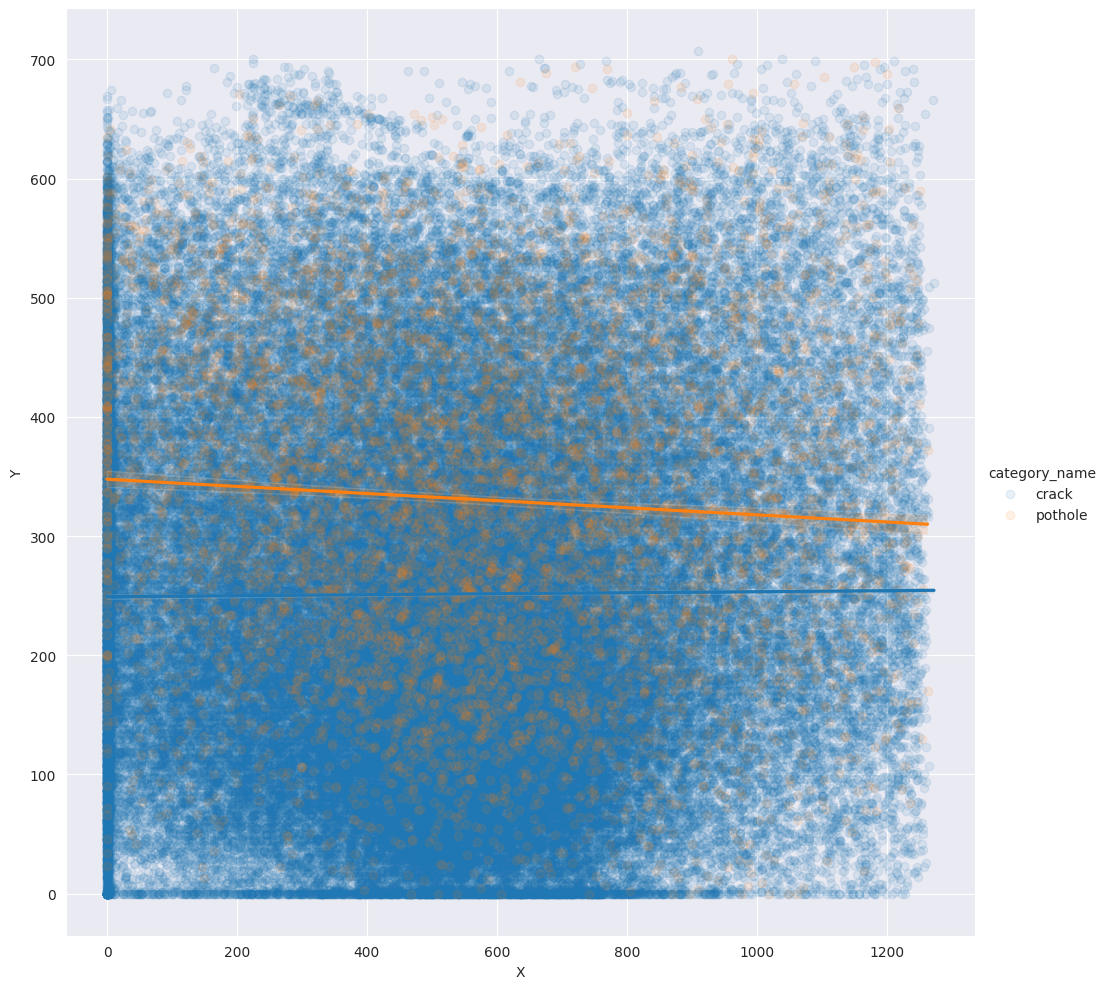

In [20]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='X', y='Y', hue='category_name', data=df, scatter_kws={'alpha':0.1}, height=10)
plt.show()

In [21]:
df[df['X']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
0,1,0,1,crack,25218,158.801763,5.0,527.0,934.0,27.0
9,10,2,1,crack,165,12.845233,1.0,248.0,55.0,3.0
11,12,3,1,crack,915,30.248967,1.0,49.0,61.0,15.0
34,35,9,1,crack,576,24.000000,1.0,73.0,48.0,12.0
59,60,11,1,crack,6783,82.358970,0.0,186.0,119.0,57.0
...,...,...,...,...,...,...,...,...,...,...
117296,117297,24259,1,crack,54782,234.055549,8.0,467.0,602.0,91.0
117324,117325,24263,1,crack,48848,221.015837,0.0,246.0,568.0,86.0
117335,117336,24266,1,crack,30212,173.815995,6.0,289.0,182.0,166.0
117342,117343,24268,1,crack,6018,77.575769,0.0,336.0,102.0,59.0


In [22]:
df[df['Y']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
4,5,1,1,crack,966,31.080541,741.0,0.0,6.0,161.0
41,42,9,1,crack,700,26.457513,671.0,5.0,25.0,28.0
218,219,38,1,crack,420,20.493902,331.0,0.0,20.0,21.0
242,243,41,1,crack,156228,395.256878,624.0,2.0,554.0,282.0
269,270,44,1,crack,1720,41.472883,755.0,0.0,40.0,43.0
...,...,...,...,...,...,...,...,...,...,...
117030,117031,24191,1,crack,34272,185.126983,405.0,0.0,63.0,544.0
117110,117111,24212,1,crack,107328,327.609524,661.0,4.0,258.0,416.0
117172,117173,24232,1,crack,897,29.949958,793.0,0.0,39.0,23.0
117177,117178,24234,1,crack,21449,146.454771,492.0,0.0,89.0,241.0


In [23]:
df[df['W']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
4,5,1,1,crack,966,31.080541,741.0,0.0,6.0,161.0
28,29,7,1,crack,208,14.422205,734.0,82.0,8.0,26.0
129,130,24,1,crack,162,12.727922,520.0,281.0,6.0,27.0
137,138,24,1,crack,360,18.973666,531.0,333.0,9.0,40.0
151,152,26,1,crack,189,13.747727,746.0,100.0,7.0,27.0
...,...,...,...,...,...,...,...,...,...,...
117255,117256,24251,1,crack,160,12.649111,565.0,272.0,5.0,32.0
117262,117263,24251,1,crack,296,17.204651,567.0,159.0,8.0,37.0
117263,117264,24251,1,crack,114,10.677078,568.0,202.0,6.0,19.0
117298,117299,24259,1,crack,342,18.493242,527.0,193.0,9.0,38.0


In [7]:
df[df['H']<10]

NameError: name 'df' is not defined

In [8]:
df.sort_values(['H','W']).tail(25)

NameError: name 'df' is not defined

In [9]:
len(df[(df['H']>1000) & (df['W']>1000)])

NameError: name 'df' is not defined

In [10]:
a = df[['image_id', 'category_id']].groupby(['image_id']).agg([pd.Series.count, pd.Series.nunique])

NameError: name 'df' is not defined

In [ ]:
a.columns

In [ ]:
a.sort_values(('category_id',   'count')).tail(16).index.tolist()

In [ ]:
df[(df['X'] > 1000) | (df['Y'] > 1000)]['image_id'].values.tolist()